# Test SIR epidemiology models for pyciemss

##  SciPy ODEint SIR model

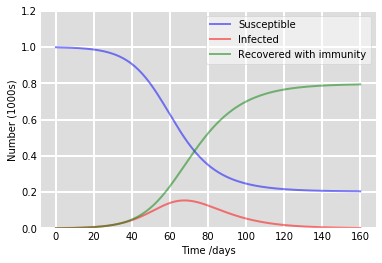

In [28]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SIR (no adjoint)

In [33]:
from torchdiffeq import odeint, odeint_adjoint, odeint_event
import torchdiffeq
import torch
import torch.nn as nn

class SIR(nn.Module):
    def __init__(self, params, initial_state, adjoint=False):
        super().__init__()
        self.N, self.beta, self.gamma = [nn.Parameter(torch.as_tensor(p)) for p in params]
        self.S0, self.I0, self.R0 = [nn.Parameter(torch.as_tensor(x0)) for x0 in initial_state]
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.odeint = odeint_adjoint if adjoint else odeint
    
    def get_tspan(self, start, end, steps):
        return torch.linspace(float(start), float(end), steps)
        
    def forward(self, t, state):
        S, I, R = state
        dSdt = -self.beta * S * I / self.N
        dIdt = self.beta * S * I / self.N - self.gamma * I
        dRdt = self.gamma * I
        return dSdt, dIdt, dRdt
    
    def get_initial_state(self):
        return self.S0, self.I0, self.R0
    
    def get_params(self):
        return self.N, self.beta, self.gamma
    

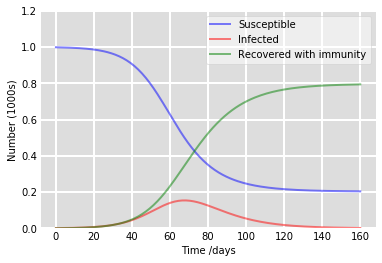

In [31]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SIR (adjoint)

In [34]:
sir_adj = SIR((N, beta, gamma), (S0, I0, R0), adjoint=True)
solution = torchdiffeq.odeint(sir_adj, sir_adj.get_initial_state(), sir_adj.get_tspan(0, 160, 160))
S, I, R = [s.detach().numpy() for s in solution]
N, beta, gamma = sir_adj.get_params()

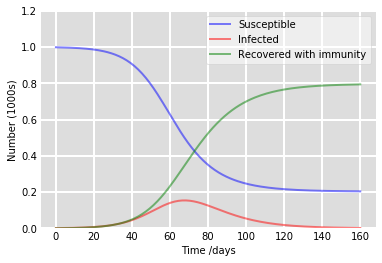

In [35]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# Test SVIIvR epidemiology model for PyCIEMSS

![SVIIvR](img/sviivr.png)

## SciPy ODE model SVIIvR model

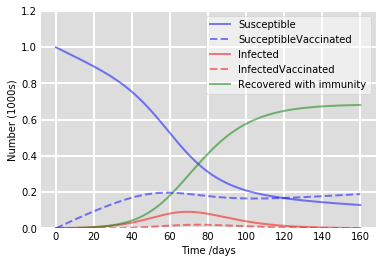

In [23]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0,  = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 -V0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, betaV, gamma, gammaV, nu = 0.2, 0.15, 1./10, 1.5/10, 0.005 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def SVIIvR(y, t, N, beta, betaV, gamma, gammaV, nu):
    S, V, I, Iv, R = y
    dSdt = -beta  * S * I  / N - beta   * S * Iv / N - nu * S 
    dVdt = -betaV * V * Iv / N - betaV  * V * I  / N + nu * S
    dIdt =  beta  * S * I  / N  + beta  * S * Iv / N - gamma  * I 
    dIvdt = betaV * V * I / N   + betaV * V * Iv / N - gammaV * Iv 
    dRdt =  gamma * I + gammaV * Iv
    return dSdt, dVdt, dIdt, dIvdt, dRdt

# Initial conditions vector
y0 = S0, V0, I0, Iv0, R0
# Integrate the SVIIvR equations over the time grid, t.
ret = scipy.integrate.odeint(SVIIvR, y0, t, args=(N, beta, betaV, gamma, gammaV, nu))
S, V, I, Iv, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, V/1000, 'b--', alpha=0.5, lw=2, label='SucceptibleVaccinated')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, Iv/1000, 'r--', alpha=0.5, lw=2, label='InfectedVaccinated')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SVIIvR model (no adjoint)

In [24]:
from torchdiffeq import odeint, odeint_adjoint, odeint_event
import torchdiffeq
import torch
import torch.nn as nn
import numpy as np

# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0,  = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 -V0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, betaV, gamma, gammaV, nu = 0.2, 0.15, 1./10, 1.5/10, 0.005 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)
class SVIIvR(nn.Module):
    def __init__(self, params, initial_state, adjoint=False):
        super().__init__()
        self.N, self.beta, self.betaV, self.gamma, self.gammaV, self.nu = [nn.Parameter(torch.as_tensor(p)) for p in params]
        self.S0,  self.V0, self.I0, self.Iv0, self.R0  = [nn.Parameter(torch.as_tensor(x0)) for x0 in initial_state]
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.odeint = odeint_adjoint if adjoint else odeint
        
    def forward(self, t, state):
        S, V, I, Iv, R = state
        dSdt = -self.beta  * S * I  / self.N - self.beta   * S * Iv / self.N - self.nu * S 
        dVdt = -self.betaV * V * Iv / self.N - self.betaV  * V * I  / self.N + self.nu * S
        dIdt =  self.beta  * S * I  / self.N  + self.beta  * S * Iv / self.N - self.gamma  * I 
        dIvdt = self.betaV * V * I / self.N   + self.betaV * V * Iv / self.N - self.gammaV * Iv 
        dRdt =  self.gamma * I + self.gammaV * Iv

        return dSdt, dVdt, dIdt, dIvdt, dRdt
    
    def get_tspan(self, start, end, steps):
        return torch.linspace(float(start), float(end), steps)
    
    def get_initial_state(self):
        return self.S0, self.V0, self.I0, self.Iv0, self.R0
    
    def get_params(self):
        return self.N, self.beta, self.betaV, self.gamma, self.gammaV, self.nu
    

In [25]:
sviivr = SVIIvR((N, beta, betaV, gamma, gammaV, nu), (S0, V0, I0, Iv0, R0), adjoint=False)
solution = torchdiffeq.odeint(sviivr, sviivr.get_initial_state(), sviivr.get_tspan(0, 160, 160))
S, V, I, Iv, R = [s.detach().numpy() for s in solution]
N, beta, betaV, gamma, gammaV, nu = sviivr.get_params()

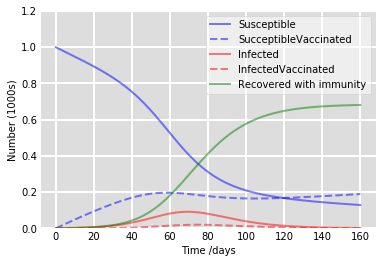

In [26]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, V/1000, 'b--', alpha=0.5, lw=2, label='SucceptibleVaccinated')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, Iv/1000, 'r--', alpha=0.5, lw=2, label='InfectedVaccinated')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SVIIvR model (adjoint)

In [36]:
sviivr_adj = SVIIvR((N, beta, betaV, gamma, gammaV, nu), (S0, V0, I0, Iv0, R0), adjoint=True)
solution = torchdiffeq.odeint(sviivr_adj, sviivr_adj.get_initial_state(), sviivr_adj.get_tspan(0, 160, 160))
S, V, I, Iv, R = [s.detach().numpy() for s in solution]
N, beta, betaV, gamma, gammaV, nu = sviivr_adj.get_params()

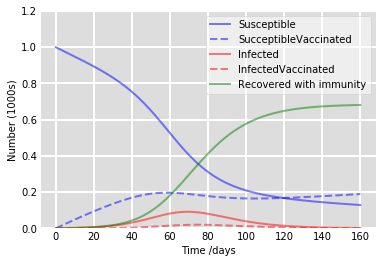

In [37]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, V/1000, 'b--', alpha=0.5, lw=2, label='SucceptibleVaccinated')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, Iv/1000, 'r--', alpha=0.5, lw=2, label='InfectedVaccinated')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

#  Test SEIIIRRD model for PyCIEMSS

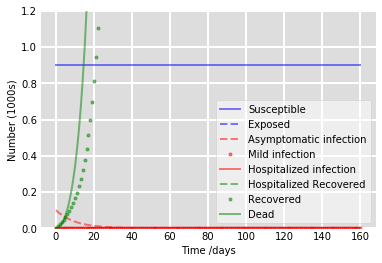

In [6]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
E0, I_asym0, I_mild0, I_hosp0, R_hosp0, R0, D0  = 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - E0 - I_asym0 - I_mild0 - I_hosp0 - R_hosp0 - R0 - D0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, delta_1, delta_2, delta_3, delta_4, delta_5, gamma_1, gamma_2,  tau = 0.2, 0.15, 1./10, .5/10, 0.5/10, 0.5, 0.1, 0.1, 0.15 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SEIIRRD model differential equations.
def SEIIIRRD(y, t, N, beta, delta_1, delta_2, delta_3, delta_4, delta_5, gamma_1, gamma_2, tau):
    S, E, I_asym, I_mild, I_hosp, R, R_hosp, D = y

    dSdt      = -beta * S * E / N
    dEdt      =  beta * S * E / N - delta_1 * E  - delta_2 * E - delta_3 * E
    dI_asymdt = delta_1 * E   - gamma_1 * I_asym
    dI_milddt = delta_2 * E   - gamma_2 * I_mild
    dI_hospdt = delta_3 * E   - delta_4 * I_hosp
    dR_hospdt = delta_4 * I_hosp - tau * R_hosp - delta_5 * R_hosp
    dRdt     = gamma_1 * I_asym + gamma_2 * I_mild + tau * R_hosp
    dDdt     = delta_5 * R_hosp

    return dSdt, dEdt, dI_asymdt, dI_milddt, dI_hospdt, dR_hospdt, dRdt, dDdt

# Initial conditions vector
y0 = S0, E0, I_asym0, I_mild0, I_hosp0, R_hosp0, R0, D0
# Integrate the SVIIvR equations over the time grid, t.
ret = scipy.integrate.odeint(SEIIIRRD, y0, t, args=(N, beta, delta_1, delta_2, delta_3, delta_4, delta_5, gamma_1, gamma_2, tau))
S, E, I_asym, I_mild, I_hosp, R_hosp, R, D = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'b--', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I_asym/1000, 'r--', alpha=0.5, lw=2, label='Asymptomatic infection')

ax.plot(t, I_mild/1000, 'r.', alpha=0.5, lw=2, label='Mild infection')
ax.plot(t, I_hosp/1000, 'r', alpha=0.5, lw=2, label='Hospitalized infection')
ax.plot(t, R_hosp/1000, 'g--', alpha=0.5, lw=2, label='Hospitalized Recovered')
ax.plot(t, R/1000, 'g.', alpha=0.5, lw=2, label='Recovered')
ax.plot(t, D/1000, 'g', alpha=0.5, lw=2, label='Dead')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# Next step: compute gradients of solution with respect to initial conditions and parameters

# Final step:  Put model into pyro with observational noise and use SVI to solve inverse problem